# SUDOKU lösen mit verschiedenen Quanten Computing Ansätzen

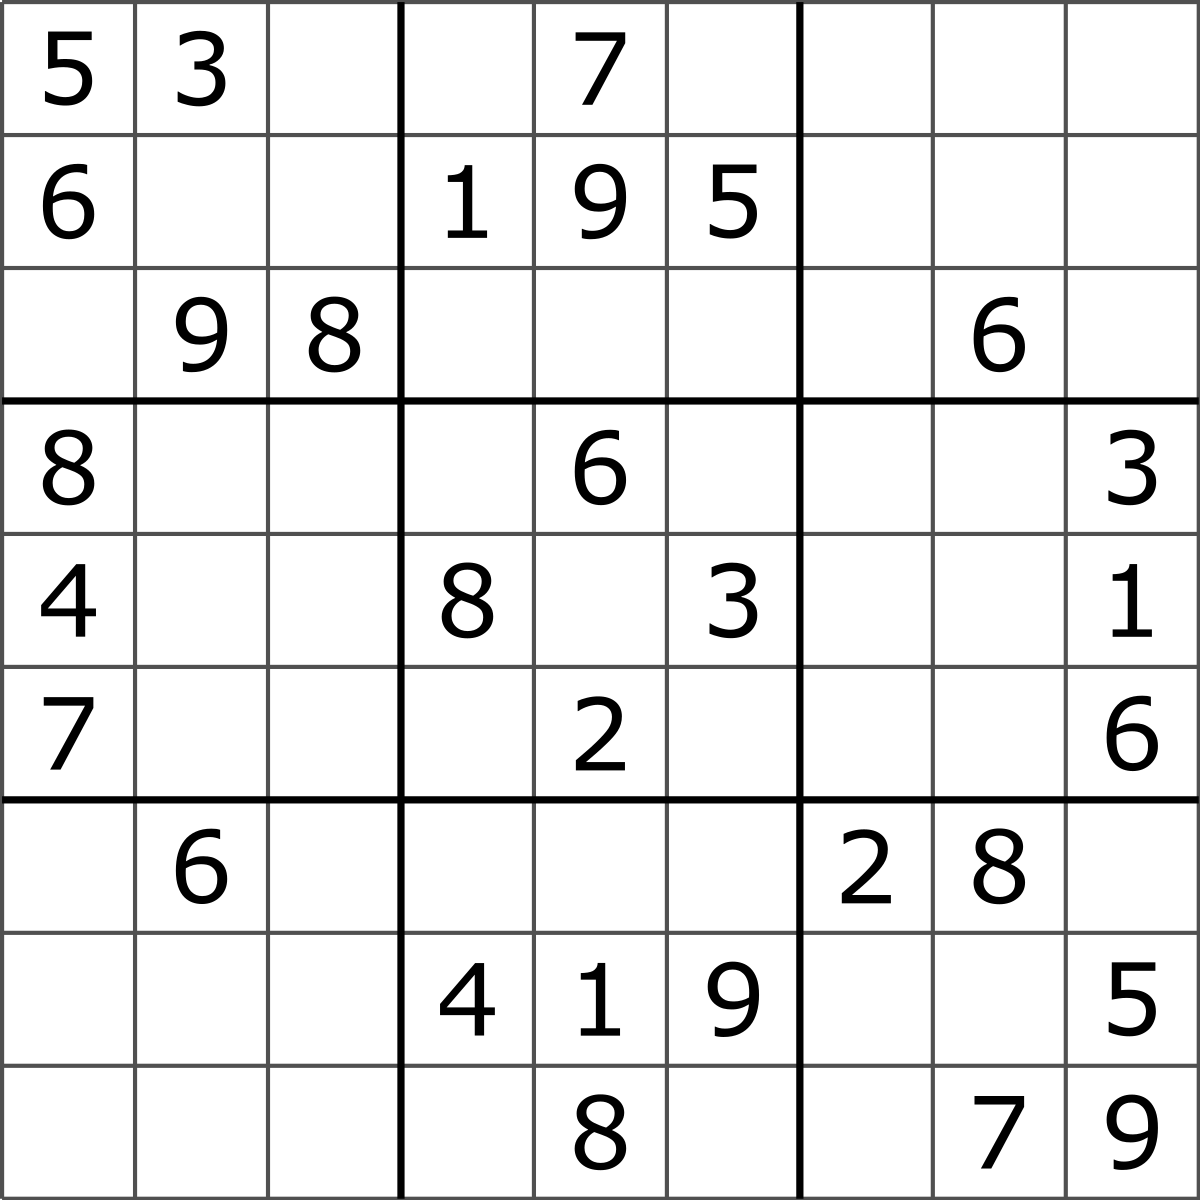

In [31]:
import utils
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 



## Variablen Deklaration:
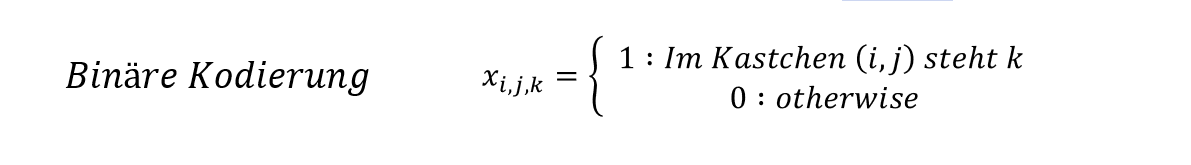

In [32]:
row_num = 9
column_num = 9
k_max = max(row_num, column_num)

num_sub_row = 3
num_sub_column = 3
block_size = 3

In [33]:
#Gewichte für Penalty funktions

alpha = 2
beta = 3
gamma = 3
delta = 2

In [34]:
# known values
known_vars = {}

known_vars[(0,0)] = 4
known_vars[(0,1)] = 2
known_vars[(0,4)] = 6

known_vars[(1,0)] = 5
known_vars[(1,3)] = 0
known_vars[(1,4)] = 8
known_vars[(1,5)] = 4

known_vars[(2,1)] = 8
known_vars[(2,2)] = 7
known_vars[(2,7)] = 5

known_vars[(3,0)] = 7
known_vars[(3,4)] = 5
known_vars[(3,8)] = 2

known_vars[(4,0)] = 3
known_vars[(4,3)] = 7
known_vars[(4,5)] = 2
known_vars[(4,8)] = 0

known_vars[(5,0)] = 6
known_vars[(5,4)] = 1
known_vars[(5,8)] = 5

known_vars[(6,1)] = 5
known_vars[(6,6)] = 1
known_vars[(6,7)] = 7

known_vars[(7,3)] = 3
known_vars[(7,4)] = 0
known_vars[(7,5)] = 8
known_vars[(7,8)] = 4

known_vars[(8,4)] = 7
known_vars[(8,7)] = 6

known_vars[(8,8)] = 8

In [35]:
all_vars = utils.get_all_vars(row_num, column_num, k_max)
var_list = utils.get_unbekannte_vars(row_num, column_num, k_max, known_vars)
prunned_list = utils.get_prunned_vars(row_num, column_num, k_max, num_sub_row, num_sub_column, block_size, known_vars)

In [36]:
len(var_list)

459

In [37]:
len(prunned_list)

153

In [38]:
p_list = []
appender = []
remember = prunned_list[0]
for tupel in prunned_list:
    if (tupel[0] != remember[0] or tupel[1] != remember[1]):
        remember = tupel
        if (len(appender) > 1):
            for a in appender:
                p_list.append(a)
        else:
            known_vars[(appender[0][0], appender[0][1])] = appender[0][2]
        appender = []
        appender.append(tupel)
    else:
        appender.append(tupel)
        
if (len(appender) > 1):
    for a in appender:
        p_list.append(a)
else:
    known_vars[(appender[0][0], appender[0][1])] = appender[0][2]

In [39]:
len(p_list)

149

In [40]:
# prunned variable list
p_list = prunned_list

-------

# Constraints and Penalty functions

In [41]:
n = len(prunned_list)
QUBO = np.zeros((n,n))

### Constraint 1: A single cell can only have one number

$$
\sum_{k=1}^{9} X_{i j k}=1, \quad \forall i j \in \text {cell}
$$

#### Here, we introduce a penalty weight $\alpha$.

$$
\alpha \sum_{i j}\left(\sum_{k=1}^{9} x_{i j k}-1\right)^{2}
$$

In [42]:
QUBO = utils.h1_penalty(alpha, QUBO, prunned_list)

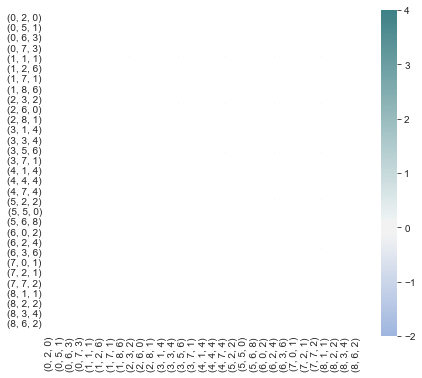

In [43]:
penalty = 'h1'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 2: Each column j can not have a duplicate number

$$
 \sum_{i} X_{i j k}=1, \quad \forall j \in \text { column }, \forall k \in K(K=\{1 . .9\})
$$

#### Here, we introduce a penalty weight $\beta$.

$$
\beta \sum_{k=1}^{9} \sum_{j}\left(\sum_{i} x_{i j k}-1\right)^{2}
$$

In [44]:
QUBO = utils.h2_penalty(beta, QUBO, prunned_list, all_vars, known_vars)

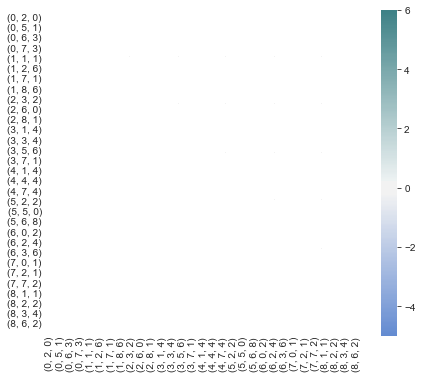

In [45]:
penalty = 'h2'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 3: Each column row i cannot have any duplicate number

$$
 \sum_{j} X_{i j k}=1, \quad \forall i \in \text { row }, \forall k \in K(K=\{1 . .9\})
$$

#### Here, we introduce a penalty weight $\gamma$.

$$
\gamma \sum_{k=1}^{9} \sum_{i}\left(\sum_{j} x_{i j k}-1\right)^{2}
$$

In [46]:
QUBO = utils.h3_penalty(gamma, QUBO, prunned_list, all_vars, known_vars)

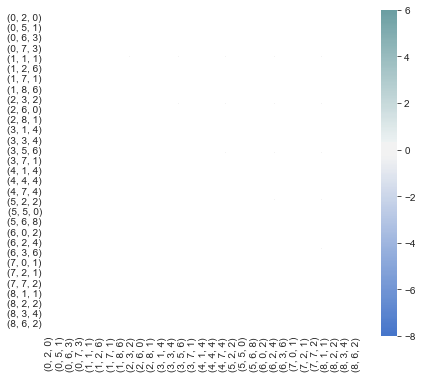

In [47]:
penalty = 'h3'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 4: Each of the subgrids cannot have any duplicate number

$$
\sum_{subgrid} x_{ijk}=1, \quad \forall k \in\{1 . .9\} \text{         } 
\forall subgrid 
$$


#### Here, we introduce a penalty weight $\delta$.

$$
\delta \sum_{k=1}^{9}\left(\sum_{subgrid} x_{ijk}-1\right)^{2}
$$

In [48]:
all_blocks = utils.get_all_blocks(num_sub_row, num_sub_column)

In [49]:
QUBO = utils.h4_penalty(delta, QUBO, prunned_list, all_vars, known_vars, block_size, all_blocks)

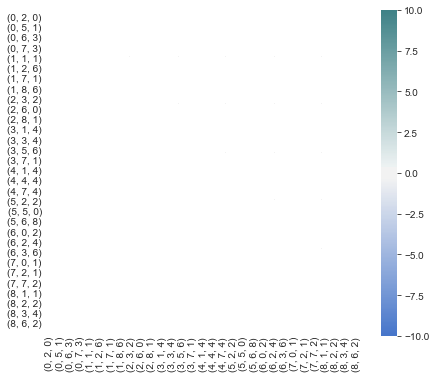

In [50]:
penalty = 'h4'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

--------

# Lösung mit QBSolve (Simulated Annealing)

In [51]:
qubo_d = utils.matrix_to_dictionary(QUBO)
sampleset = utils.on_QBsolve(qubo_d)
first_sample = sampleset.samples()[0]

In [52]:
def check_solution(solution: list, subunit_size: int):
    #check row sum
    for row in solution:
        if len(set(row)) != len(row):
            return False
    #check col sum
    for col_index in range(len(solution[0])):
        col = []
        for row in solution:
            col.append(row[col_index])
        if len(set(col)) != len(col):
            return False
    #check sub unit sum
    subunits_width = int(len(solution[0])/subunit_size)
    subunit_height = int(len(solution[0])/subunit_size)
    for i in range(subunits_width):
        for j in range(subunit_height):
            sub = []
            for m in range(subunit_size):
                for n in range(subunit_size):
                    sub.append(solution[m+i*subunit_size][n+j*subunit_size])
            if len(set(sub)) != len(sub):
                return False
    return True

In [53]:
first_sample
solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, first_sample)
solution = np.asarray(solution)
check_solution(solution, 3)

True

In [54]:
for sample in sampleset:
    result = [y for _, y in sample.items()]
    solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)
    print(solution)
    print()

[[4. 2. 3. 5. 6. 7. 8. 0. 1.]
 [5. 6. 1. 0. 8. 4. 2. 3. 7.]
 [0. 8. 7. 2. 3. 1. 4. 5. 6.]
 [7. 4. 8. 6. 5. 0. 3. 1. 2.]
 [3. 1. 5. 7. 4. 2. 6. 8. 0.]
 [6. 0. 2. 8. 1. 3. 7. 4. 5.]
 [8. 5. 0. 4. 2. 6. 1. 7. 3.]
 [1. 7. 6. 3. 0. 8. 5. 2. 4.]
 [2. 3. 4. 1. 7. 5. 0. 6. 8.]]

[[4. 2. 3. 5. 6. 7. 8. 0. 1.]
 [5. 6. 1. 0. 8. 4. 3. 3. 7.]
 [0. 8. 7. 2. 3. 1. 4. 5. 6.]
 [7. 0. 8. 6. 5. 3. 3. 4. 2.]
 [3. 1. 5. 7. 4. 2. 6. 8. 0.]
 [6. 4. 2. 8. 1. 0. 7. 3. 5.]
 [8. 5. 0. 4. 2. 6. 1. 7. 3.]
 [1. 7. 6. 3. 0. 8. 5. 2. 4.]
 [2. 3. 4. 1. 7. 5. 0. 6. 8.]]

[[4. 2. 3. 5. 6. 7. 8. 0. 1.]
 [5. 6. 1. 0. 8. 4. 2. 3. 7.]
 [0. 8. 7. 2. 3. 1. 4. 5. 6.]
 [7. 4. 8. 6. 5. 3. 3. 1. 2.]
 [3. 1. 5. 7. 4. 2. 6. 8. 0.]
 [6. 4. 2. 8. 1. 3. 7. 4. 5.]
 [8. 5. 0. 4. 2. 6. 1. 7. 3.]
 [1. 7. 6. 3. 0. 8. 5. 2. 4.]
 [2. 3. 4. 1. 7. 5. 0. 6. 8.]]

[[4. 2. 3. 5. 6. 7. 8. 0. 1.]
 [5. 6. 1. 0. 8. 4. 2. 3. 7.]
 [0. 8. 7. 2. 3. 1. 4. 5. 6.]
 [7. 4. 8. 8. 5. 0. 3. 1. 2.]
 [3. 1. 5. 7. 4. 2. 6. 8. 0.]
 [6. 0. 8. 8. 1. 3. 7. 4. 5.]
 [8.

-----

# Lösung mit DWave (DWave Advantage)

In [57]:
sampleset = utils.on_DWave(QUBO, 100)

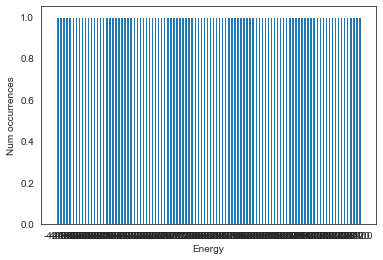

In [58]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt

# Make a random dataset:
energies = sampleset.record.energy
num_occ = sampleset.record.num_occurrences
y_pos = np.arange(len(energies))

# Create bars
plt.bar(y_pos, num_occ)

# Create names on the x-axis
plt.xticks(y_pos, energies)
plt.xlabel('Energy')
plt.ylabel('Num occurrences')
# Show graphic
#plt.show()
plt.savefig('dwave.jpg')

In [60]:
first_sample = sampleset.samples()[0]
solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, first_sample)
solution = np.asarray(solution)
check_solution(solution, 3)

False

In [61]:
solution

array([[4., 2., 0., 5., 6., 7., 8., 8., 3.],
       [5., 6., 3., 0., 8., 4., 3., 2., 7.],
       [0., 8., 7., 2., 3., 1., 4., 5., 1.],
       [7., 0., 8., 6., 5., 0., 6., 3., 2.],
       [3., 1., 5., 7., 4., 2., 8., 8., 0.],
       [6., 4., 2., 8., 1., 3., 7., 4., 5.],
       [8., 5., 0., 4., 2., 6., 1., 7., 3.],
       [1., 7., 6., 3., 0., 8., 5., 2., 4.],
       [2., 4., 1., 4., 7., 5., 0., 6., 8.]])

In [28]:
#Dwave Hybrid
def on_DWave_Hybrid(QUBO):
    bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(QUBO)
    sampler = LeapHybridSampler()
    # reding num_reads responses from the sampler
    sampleset = sampler.sample(bqm)
    return sampleset

import dimod
import neal
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.system import LeapHybridSampler


In [29]:
sampleset = on_DWave_Hybrid(QUBO)
first_sample = sampleset.samples()[0]
solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, first_sample)
solution = np.asarray(solution)
check_solution(solution, 3)

True

In [30]:
solution

array([[4., 2., 3., 5., 6., 7., 8., 0., 1.],
       [5., 6., 1., 0., 8., 4., 2., 3., 7.],
       [0., 8., 7., 2., 3., 1., 4., 5., 6.],
       [7., 4., 8., 6., 5., 0., 3., 1., 2.],
       [3., 1., 5., 7., 4., 2., 6., 8., 0.],
       [6., 0., 2., 8., 1., 3., 7., 4., 5.],
       [8., 5., 0., 4., 2., 6., 1., 7., 3.],
       [1., 7., 6., 3., 0., 8., 5., 2., 4.],
       [2., 3., 4., 1., 7., 5., 0., 6., 8.]])

In [49]:
max_n = 5
for i, sample in enumerate(sampleset):
    if (i < max_n):
        result = [y for _, y in sample.items()]
        solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)
        print(solution)
        print()

[[3. 2. 1. 0.]
 [0. 1. 2. 3.]]

[[3. 2. 1. 0.]
 [0. 1. 3. 2.]]

[[3. 2. 1. 0.]
 [0. 1. 3. 2.]]

[[3. 2. 1. 0.]
 [0. 1. 3. 2.]]

[[3. 2. 1. 0.]
 [0. 1. 2. 3.]]



----------

# Lösung mit QAOA (Qiskits QuadraticProgram)

In [70]:
quadr_program = utils.QUBO_to_QuadraticProgram(QUBO)
print(quadr_program)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: [ - 12 x0^2 + 8 x0*x2 + 4 x0*x4 - 12 x1^2 + 4 x1*x2 - 12 x2^2 + 4 x2*x6
      + 12 x2*x8 - 12 x3^2 + 4 x3*x4 - 12 x4^2 + 8 x4*x6 + 8 x4*x8 - 12 x5^2
      + 4 x5*x6 + 12 x5*x7 - 12 x6^2 + 12 x6*x8 - 12 x7^2 + 4 x7*x8 - 12 x8^2
      ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1
 0 <= x6 <= 1
 0 <= x7 <= 1
 0 <= x8 <= 1

Binaries
 x0 x1 x2 x3 x4 x5 x6 x7 x8
End



optimal params:       {ParameterVectorElement(θ[0]): 3.424899615115572, ParameterVectorElement(θ[1]): 5.730426166887669}
optimal value:        -7.857421875


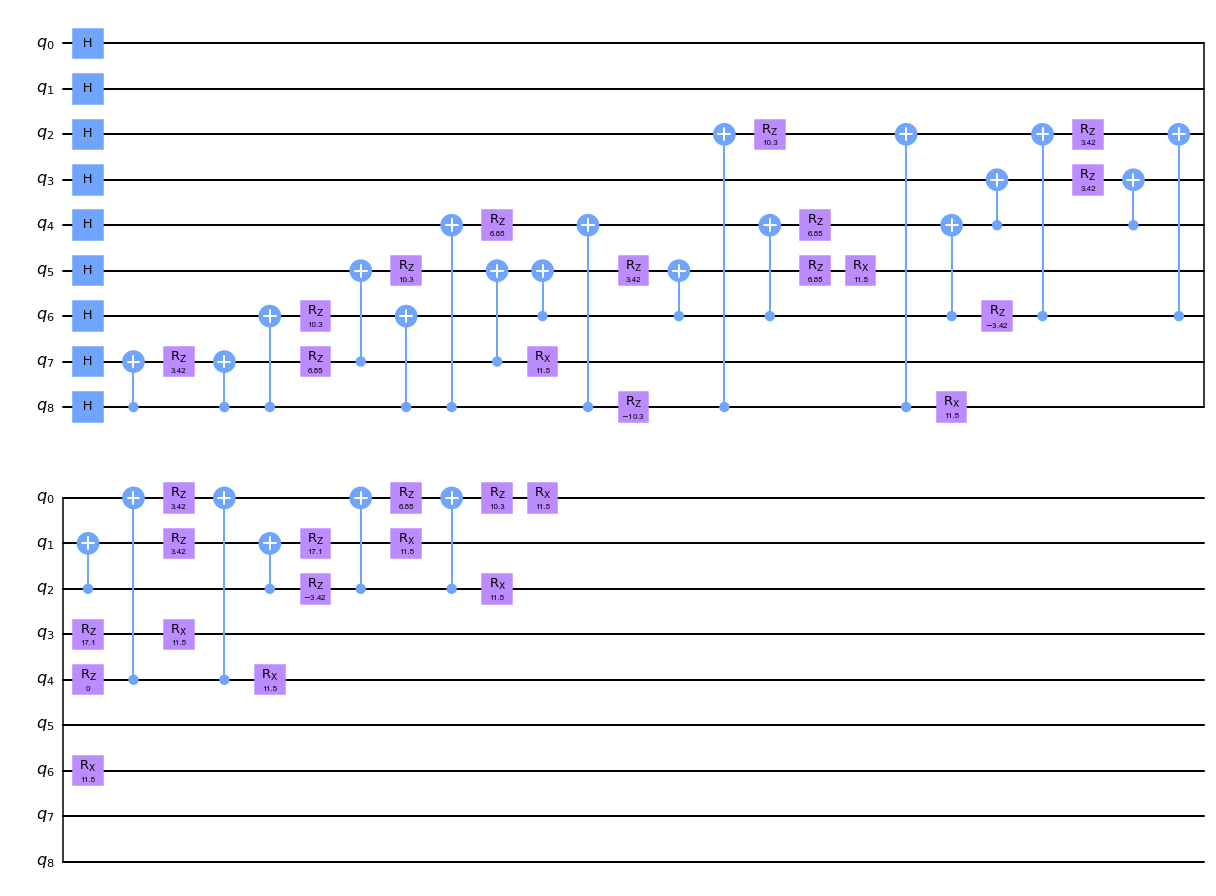

In [71]:
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')
qc = utils.on_qiskit(quadr_program, backend, with_graphic = False)[1]
display(qc.draw('mpl'))

In [74]:
from qiskit import QuantumCircuit, Aer, assemble, IBMQ, transpile

In [75]:
for kk in range(4):
    trans_qc = transpile(qc, basis_gates=['cx', 'u3'], optimization_level=kk)
    
    #display(trans_qc.draw())
    print('Optimization Level {}'.format(kk))
    print('Depth:', trans_qc.depth())
    print('Gate counts:', trans_qc.count_ops())

Optimization Level 0
Depth: 27
Gate counts: OrderedDict([('u3', 39), ('cx', 24)])
Optimization Level 1
Depth: 26
Gate counts: OrderedDict([('u3', 34), ('cx', 24)])
Optimization Level 2
Depth: 26
Gate counts: OrderedDict([('u3', 34), ('cx', 24)])
Optimization Level 3
Depth: 26
Gate counts: OrderedDict([('u3', 34), ('cx', 24)])


In [78]:
trans_qc.count_ops()['u3'] + 10 * trans_qc.count_ops()['cx']

274

In [72]:
costs = utils.get_costs(qc)

OrderedDict([('u3', 39), ('cx', 24)])
Cost: 279


In [ ]:
backend = Aer.get_backend('qasm_simulator')
counts = utils.measure_ciruit(qc, backend, shots = 1000)
result = counts.most_frequent()

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [ ]:
solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)
print(solution)